## Test Dirichet Process Gaussian Mixture Model ##

This notebook contains code to do integration tests on the dirichlet process mixture model. 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from dirichlet_process import DPGMM
import dirichlet_process as dp
from sklearn.preprocessing import normalize
from IPython.core.debugger import Tracer
import itertools
from tqdm import tqdm
import mcmc

In [2]:
%matplotlib inline
plt.style.use('seaborn-talk')
%pdb on

Automatic pdb calling has been turned ON


### Setup the Model ###

In [3]:
means = np.array([-1, 2])
variances = np.array([.5, .5])
mixing_proportions = np.array([.1, .9])
num_datapoints = 20000
alpha = 1

In [4]:
data = mcmc.gmm_rvs(size=num_datapoints, means=means, scales=np.sqrt(variances), pvals=mixing_proportions)

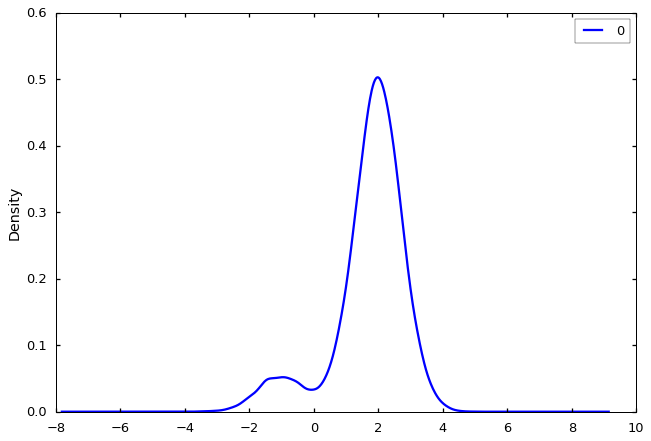

In [5]:
pd.DataFrame(data).plot(kind='kde')

## Setup the Model ##

In [6]:
dpgmm_model = DPGMM(data, comp_means=means, comp_vars=variances, alpha=alpha, pvals=mixing_proportions)

This may not have the same size as the data. If it adds a new component, this will be smaller. 

The size of the indicator array is 20000


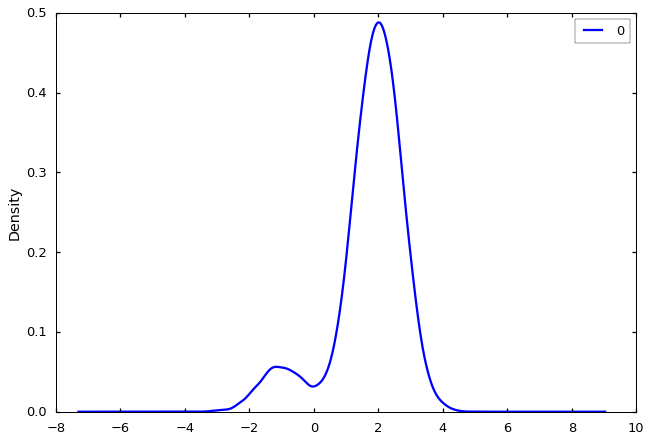

In [7]:
new_data, counts = dpgmm_model.sample(num_datapoints, return_counts=True)
indicators = np.asarray([val for idx,arr in enumerate(counts) 
                        if idx > 0 for val in np.full(shape=arr, fill_value=idx-1, dtype='int')])
indicators = np.hstack([indicators, np.zeros(new_data.size - indicators.size, dtype='int')])
print('The size of the indicator array is ' + str(indicators.size))
pd.DataFrame(new_data).plot(kind='kde')

In [8]:
dpgmm_model.indicators = indicators
dpgmm_model.data = new_data

In [9]:
prior = {'mean': 0, 'nu': 5, 'alpha': 5, 'beta': 4}

In [10]:
hyperprior = {'global_mean': {'mean': 0, 'variance': 2},
              'nu': {'alpha': 3, 'beta': 10},
              'alpha': {'alpha': 3, 'beta': 6},
              'beta': {'alpha': 3, 'beta': 4},
              'concentration': {'alpha':3, 'beta': 40 }}

In [11]:
nsims = 2000
num_draws_per_sample = 100
percentiles = (5, 50, 95)

## Estimate the Model ##

In [12]:
indicator_draws = np.empty((nsims, dpgmm_model.data_dimension), dtype='int')
comp_means_draws = []
comp_vars_draws = []
nu_draws = np.empty(nsims)
alpha_draws = np.empty(nsims)
beta_draws = np.empty(nsims)
concentration_draws = np.empty(nsims)
variance_params_accepted = np.empty(nsims)
concentration_accepted = np.empty(nsims)

In [13]:
for idx in tqdm(range(nsims)):
    draw = dpgmm_model(hyperprior,draw_hyperparameters=True, draw_global_mean=True, draw_concentration=False, 
                       library='tmpfile.hdf')
    
    indicator_draws[idx] = draw['indicators']
    comp_means_draws.append(draw['comp_means'])
    comp_vars_draws.append(draw['comp_vars'])
    nu_draws[idx] = draw['nu']
    alpha_draws[idx] = draw['alpha']
    beta_draws[idx] = draw['beta']
    concentration_draws[idx] = draw['concentration']
    variance_params_accepted[idx] = draw['variance_params_accepted']
    concentration_accepted[idx] = draw['concentration_accepted']

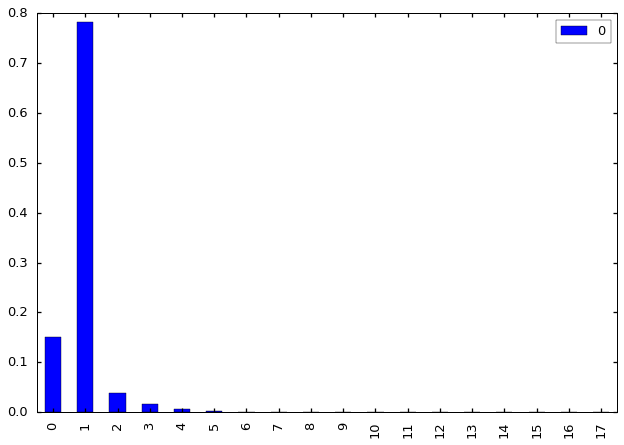

In [14]:
pd.DataFrame(np.bincount(indicator_draws.ravel()) / indicator_draws.size).plot(kind='bar')

In [15]:
pd.DataFrame(comp_means_draws).mean()

0    -0.283957
1     2.104162
2     1.427859
3     1.451959
4     1.466012
5     1.480197
6     1.488184
7     1.490738
8     1.494029
9     1.497357
10    1.500686
11    1.503816
12    1.507811
13    1.511626
14    1.517264
15    1.516269
16    1.518741
17    1.517663
dtype: float64

In [16]:
pd.DataFrame(comp_vars_draws).mean()

0     1.530733
1     0.440043
2     0.550852
3     0.624791
4     0.430018
5     0.589606
6     0.618780
7     0.604483
8     0.735883
9     0.735181
10    0.813515
11    0.686490
12    0.778283
13    0.765098
14    0.815664
15    1.158853
16    0.734711
17    0.477455
dtype: float64

In [17]:
pd.DataFrame(np.percentile(nu_draws, q=percentiles)).round(2)

0
0   48.71
1  106.74
2  186.01

In [18]:
pd.DataFrame(np.percentile(alpha_draws, q=percentiles)).round(2)

0
0  0.50
1  1.01
2  1.84

In [19]:
pd.DataFrame(np.percentile(beta_draws, q=percentiles)).round(2)

0
0  0.05
1  0.20
2  2.13

In [20]:
pd.DataFrame(np.percentile(concentration_draws, q=percentiles)).round(2)

0
0  1
1  1
2  1

In [21]:
print('The percentage of the variance hyperameters that were accepte is ' + str(np.mean(variance_params_accepted)))

The percentage of the variance hyperameters that were accepte is 0.614


In [22]:
print('The percentage of the concentration parameters that were accepte is ' + 
      str(np.mean(concentration_accepted)))

The percentage of the concentration parameters that were accepte is 0.0


## We now compare the moments of the estimated distribution to the real distribution ##

In [23]:
sample_to_compare = pd.DataFrame(mcmc.gmm_rvs(size=num_draws_per_sample * (nsims - 500), 
                                            pvals=mixing_proportions,
                                            means=means,
                                            scales=np.sqrt(variances)))
sample_to_compare.describe()

0
count  150000.000000
mean        1.695424
std         1.146377
min        -3.661940
25%         1.315229
50%         1.897186
75%         2.415213
max         5.122321

In [24]:
samples = np.array([mcmc.gmm_rvs(size=num_draws_per_sample,
            pvals=np.bincount(indicator_draws[idx]) / indicator_draws[idx].size,
            means=comp_means_draws[idx][np.isfinite(comp_means_draws[idx])],
            scales=np.sqrt(comp_vars_draws[idx][np.isfinite(comp_vars_draws[idx])])) 
          for idx in range(500, nsims)]).ravel()

In [25]:
new_sample = pd.DataFrame(samples)
new_sample.describe()

0
count  150000.000000
mean        1.704494
std         1.148168
min        -5.497498
25%         1.325285
50%         1.902384
75%         2.423180
max         5.391584

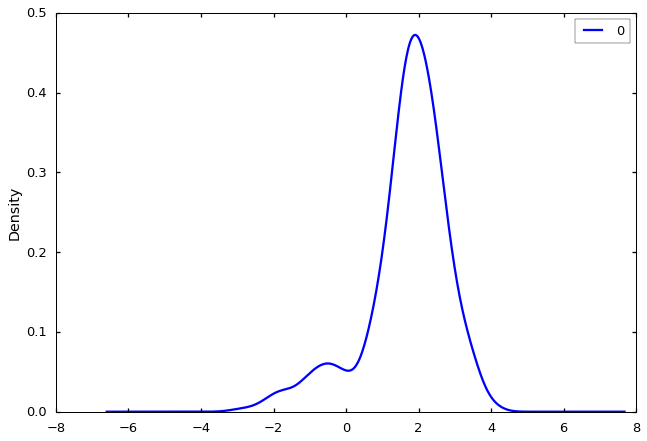

In [26]:
pd.DataFrame(dpgmm_model.sample(1000)).plot(kind='kde')

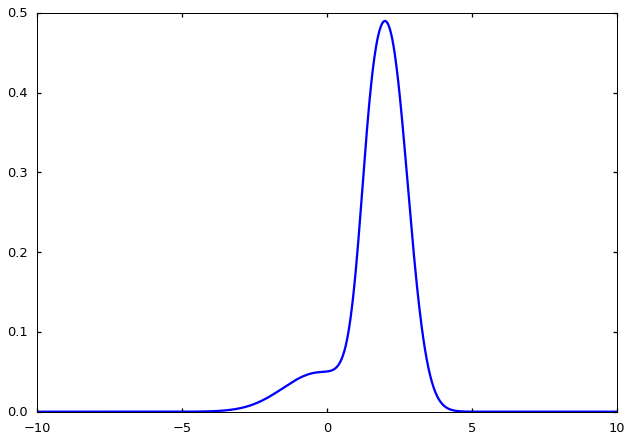

In [27]:
xvals = np.linspace(-10, 10, 1000)
yvals = dpgmm_model.pdf(xvals)
plt.plot(xvals, yvals)